<a href="https://colab.research.google.com/github/harrymkwn/InfluenceAnalysis/blob/master/AllEmointGen_Norm_E2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from gensim.models import KeyedVectors
from sklearn.model_selection import train_test_split
from google.colab import  drive
drive.mount('/content/drive')
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
device_name = tf.test.gpu_device_name()
print(device_name)
df = pd.read_csv('/content/drive/MyDrive/InfluenceAnalysis/Emoint/E2.csv')
df = df.sample(frac=1,random_state=32)

Mounted at /content/drive
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
/device:GPU:0


In [2]:
print(df.columns)

Index(['id', 'tweets', 'emotion', 'intensity'], dtype='object')


In [3]:
category_dict = {0:[1,0,0,0],1:[0,1,0,0],2:[0,0,1,0],3:[0,0,0,1]}
data_tweet = [x.lower().split() for x in df['tweets']]
data_cat = np.array([category_dict[x] for x in df['emotion']])

In [4]:
print(data_tweet[:5])
print(data_cat[:5])

[['collect', 'all', 'the', 'time', 'when', 'minerva', 'would', 'chew', 'on', 'hi', 'cape', 'begin', 'to', 'shiver', 'run', 'a', 'hand', 'through', 'hi', 'hair', 'nnyou', 'can', 'surelynardentfli'], ['sanatana', 'lopez', 'is', 'definit', 'me', 'face_with_tears_of_joy'], ['2', 'biggest', 'fear', 'incur', 'std', 'and', 'pregnancyi', 'mean', 'theyr', 'basic', 'the', 'same', 'thing', 'anyway', 'forlif', 'annoy', 'weirdsmel'], ['i', 'feel', 'so', 'bless', 'to', 'work', 'with', 'the', 'famili', 'that', 'i', 'nanni', 'for', 'red_heart', 'noth', 'but', 'love', 'amp', 'appreci', 'make', 'me', 'smile'], ['rover', 'what', 'highlight', 'i', 'would', 'imagin', 'you', 'will', 'onli', 'have', 'second', 'of', 'highlight', 'for', 'the', 'whole', 'season', 'so', 'far', 'venkysout']]
[[1 0 0 0]
 [0 0 1 0]
 [0 1 0 0]
 [0 0 1 0]
 [1 0 0 0]]


In [5]:
# Parameters
Min_count = 0
Embedding_size = 200
Window_size = 5
Negative_sampling = 00

In [6]:
w2v_sg = Word2Vec(min_count=Min_count,
                     window=Window_size,
                     size=Embedding_size,
                     negative=Negative_sampling,sg=1)
w2v_sg.build_vocab(data_tweet)
w2v_sg.train(data_tweet, total_examples=w2v_sg.corpus_count, epochs=5)
w2v_cbow = Word2Vec(min_count=Min_count,
                     window=Window_size,
                     size=Embedding_size,
                     negative=Negative_sampling,sg=0)
w2v_cbow.build_vocab(data_tweet)
w2v_cbow.train(data_tweet, total_examples=w2v_cbow.corpus_count, epochs=5)
w2v_sg.wv.init_sims(True)
w2v_cbow.wv.init_sims(True)

In [7]:
vocab_sg = w2v_sg.wv.vocab
vocab_sg = [x for x in vocab_sg]
vocab_cbow = w2v_cbow.wv.vocab
vocab_cbow = [x for x in vocab_cbow] 
vocab_glove = {}
with open("/content/drive/My Drive/InfluenceAnalysis/glove/glove.twitter.27B.200d.txt", 'r', encoding="utf-8") as f:
  for line in f:
      values = line.split()
      word = values[0]
      vector = np.asarray(values[1:], "float32")
      vocab_glove[word] = vector

In [8]:
print(len(vocab_sg))
print(len(vocab_cbow))


13750
13750


In [9]:
batch_size = 100
Max_input_size = max([len(x) for x in data_tweet])


In [10]:
def vec_gen(w2v,vocab,data_tweet,data_cat,batch_size,Max_input_size,Embedding_size):
  while True:
    for k in range(int(len(data_tweet)/batch_size)):
      temp = np.array([np.array([w2v.wv.get_vector(i) for i in x if i in vocab]) for x in data_tweet[k*(batch_size):(k+1)*(batch_size)]])
      temp = np.array([np.pad(x.flatten(),(0,Max_input_size*Embedding_size-len(x.flatten()))).reshape(Max_input_size,Embedding_size) for x in temp])
      tempres = data_cat[k*(batch_size):(k+1)*(batch_size)]
      yield (temp,tempres)

def glove_gen(vocab,data_tweet,data_cat,batch_size,Max_input_size,Embedding_size):
  while True:
    for k in range(int(len(data_tweet)/batch_size)):
      temp = np.array([np.array([vocab[i] for i in x if i in vocab.keys()]) for x in data_tweet[k*(batch_size):(k+1)*(batch_size)]])
      temp = np.array([np.pad(x.flatten(),(0,Max_input_size*Embedding_size-len(x.flatten()))).reshape(Max_input_size,Embedding_size) for x in temp])
      tempres = data_cat[k*(batch_size):(k+1)*(batch_size)]
      yield (temp,tempres)


In [11]:
X_train, X_test, y_train, y_test = train_test_split(data_tweet, data_cat, test_size=0.20, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=42)
result_table = [0,0,0,0,0,0,0,0,0]

In [12]:
epochs = 60

In [13]:
from keras import backend as K
def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recalls = true_positives / (possible_positives + K.epsilon())
        return recalls
def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precisions = true_positives / (predicted_positives + K.epsilon())
        return precisions
def f1(y_true, y_pred):
    precisions = precision(y_true, y_pred)
    recalls = recall(y_true, y_pred)
    return 2*((precisions*recalls)/(precisions+recalls+K.epsilon()))

In [14]:
model_sg = tf.keras.Sequential()
model_sg.add(tf.keras.Input(shape=(Max_input_size,Embedding_size)))
model_sg.add(tf.keras.layers.LSTM(64))
model_sg.add(tf.keras.layers.Dropout(0.2))
model_sg.add(tf.keras.layers.Dense(64,activation='relu'))
model_sg.add(tf.keras.layers.Dropout(0.2))
model_sg.add(tf.keras.layers.Dense(4, activation='softmax'))
model_sg.compile(loss='categorical_crossentropy',optimizer='adam', 
                           metrics=['accuracy',f1,precision,recall])
sg_train_gen=vec_gen(w2v_sg,vocab_sg,X_train,y_train,batch_size,Max_input_size,Embedding_size)
sg_val_gen=vec_gen(w2v_sg,vocab_sg,X_val,y_val,batch_size,Max_input_size,Embedding_size)
history_sg_lstm = model_sg.fit_generator(sg_train_gen,validation_data=sg_val_gen,validation_steps=int((len(X_val)/batch_size)+1),steps_per_epoch=int((len(X_train)/batch_size)+1),epochs=epochs)
history = model_sg.evaluate(x = vec_gen(w2v_sg,vocab_sg,X_test,y_test,batch_size,Max_input_size,Embedding_size),steps=int(len(y_test)/batch_size))
print(history)

result_table[0]=history[1]
print("SG_LSTM")


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  after removing the cwd from sys.path.


Epoch 1/60
46/46 [==============================] - 37s 101ms/step - loss: 1.3813 - accuracy: 0.3123 - f1: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.3734 - val_accuracy: 0.3183 - val_f1: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/60
46/46 [==============================] - 4s 87ms/step - loss: 1.3697 - accuracy: 0.3232 - f1: 0.0027 - precision: 0.0320 - recall: 0.0015 - val_loss: 1.3399 - val_accuracy: 0.3342 - val_f1: 0.0746 - val_precision: 0.6282 - val_recall: 0.0400
Epoch 3/60
46/46 [==============================] - 4s 85ms/step - loss: 1.3400 - accuracy: 0.3515 - f1: 0.0740 - precision: 0.6012 - recall: 0.0409 - val_loss: 1.2928 - val_accuracy: 0.3942 - val_f1: 0.1519 - val_precision: 0.5981 - val_recall: 0.0875
Epoch 4/60
46/46 [==============================] - 4s 87ms/step - loss: 1.2574 - accuracy: 0.4296 - f1: 0.2100 - precision: 0.6554 - recall: 0.1270 - val_loss: 1.2818 - val_accuracy: 0.4075 - val_f1: 0.2518 - val_p

In [15]:
model_sg_bi = tf.keras.Sequential()
model_sg_bi.add(tf.keras.Input(shape=(Max_input_size,Embedding_size)))
model_sg_bi.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64),merge_mode='concat'))
model_sg_bi.add(tf.keras.layers.Dropout(0.2))
model_sg_bi.add(tf.keras.layers.Dense(64,activation='relu'))
model_sg_bi.add(tf.keras.layers.Dropout(0.2))
model_sg_bi.add(tf.keras.layers.Dense(4, activation='softmax'))
model_sg_bi.compile(loss='categorical_crossentropy',optimizer='adam', 
                           metrics=['accuracy',f1,precision,recall])
history_sg_bi = model_sg_bi.fit_generator(sg_train_gen,validation_data=sg_val_gen,validation_steps=int((len(X_val)/batch_size)+1),steps_per_epoch=int((len(X_train)/batch_size)+1),epochs=epochs)
history = model_sg_bi.evaluate(x = vec_gen(w2v_sg,vocab_sg,X_test,y_test,batch_size,Max_input_size,Embedding_size),steps=int(len(y_test)/batch_size))
print(history)

result_table[1]=history[1]
print("SG_BI")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  after removing the cwd from sys.path.


Epoch 1/60
46/46 [==============================] - 7s 100ms/step - loss: 1.3804 - accuracy: 0.2984 - f1: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.3671 - val_accuracy: 0.3175 - val_f1: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/60
46/46 [==============================] - 4s 86ms/step - loss: 1.3556 - accuracy: 0.3263 - f1: 0.0049 - precision: 0.0541 - recall: 0.0026 - val_loss: 1.3209 - val_accuracy: 0.3700 - val_f1: 0.1204 - val_precision: 0.5554 - val_recall: 0.0683
Epoch 3/60
46/46 [==============================] - 4s 85ms/step - loss: 1.2819 - accuracy: 0.4239 - f1: 0.1137 - precision: 0.6574 - recall: 0.0648 - val_loss: 1.2605 - val_accuracy: 0.4375 - val_f1: 0.2658 - val_precision: 0.5609 - val_recall: 0.1750
Epoch 4/60
46/46 [==============================] - 4s 85ms/step - loss: 1.1828 - accuracy: 0.4949 - f1: 0.3007 - precision: 0.6594 - recall: 0.1978 - val_loss: 1.1932 - val_accuracy: 0.4875 - val_f1: 0.3588 - val_pr

In [16]:
model_sg_rnn = tf.keras.Sequential()
model_sg_rnn.add(tf.keras.Input(shape=(Max_input_size,Embedding_size)))
model_sg_rnn.add(tf.keras.layers.SimpleRNN(64))
model_sg_rnn.add(tf.keras.layers.Dropout(0.2))
model_sg_rnn.add(tf.keras.layers.Dense(64,activation='relu'))
model_sg_rnn.add(tf.keras.layers.Dropout(0.2))
model_sg_rnn.add(tf.keras.layers.Dense(4, activation='softmax'))
model_sg_rnn.compile(loss='categorical_crossentropy',optimizer='adam', 
                           metrics=['accuracy',f1,precision,recall])
history_sg_rnn = model_sg_rnn.fit_generator(sg_train_gen,validation_data=sg_val_gen,validation_steps=int((len(X_val)/batch_size)+1),steps_per_epoch=int((len(X_train)/batch_size)+1),epochs=epochs)
history = model_sg_rnn.evaluate(x = vec_gen(w2v_sg,vocab_sg,X_test,y_test,batch_size,Max_input_size,Embedding_size),steps=int(len(y_test)/batch_size))
print(history)


result_table[2]=history[1]
print("SG_RNN")

Epoch 1/60


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  after removing the cwd from sys.path.


46/46 [==============================] - 6s 106ms/step - loss: 1.3900 - accuracy: 0.2621 - f1: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.3890 - val_accuracy: 0.3058 - val_f1: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/60
46/46 [==============================] - 5s 100ms/step - loss: 1.3532 - accuracy: 0.3347 - f1: 0.0031 - precision: 0.1076 - recall: 0.0016 - val_loss: 1.3714 - val_accuracy: 0.3367 - val_f1: 0.0363 - val_precision: 0.4424 - val_recall: 0.0192
Epoch 3/60
46/46 [==============================] - 5s 98ms/step - loss: 1.3132 - accuracy: 0.3783 - f1: 0.0546 - precision: 0.6634 - recall: 0.0291 - val_loss: 1.3509 - val_accuracy: 0.3450 - val_f1: 0.0563 - val_precision: 0.5239 - val_recall: 0.0300
Epoch 4/60
46/46 [==============================] - 5s 99ms/step - loss: 1.2611 - accuracy: 0.4197 - f1: 0.1318 - precision: 0.6783 - recall: 0.0756 - val_loss: 1.3458 - val_accuracy: 0.3358 - val_f1: 0.0960 - val_precision: 0

In [17]:
model_cbow = tf.keras.Sequential()
model_cbow.add(tf.keras.Input(shape=(Max_input_size,Embedding_size)))
model_cbow.add(tf.keras.layers.LSTM(64))
model_cbow.add(tf.keras.layers.Dropout(0.2))
model_cbow.add(tf.keras.layers.Dense(64,activation='relu'))
model_cbow.add(tf.keras.layers.Dropout(0.2))
model_cbow.add(tf.keras.layers.Dense(4, activation='softmax'))
model_cbow.compile(loss='categorical_crossentropy',optimizer='adam', 
                           metrics=['accuracy',f1,precision,recall])
cbow_train_gen=vec_gen(w2v_cbow,vocab_cbow,X_train,y_train,batch_size,Max_input_size,Embedding_size)
cbow_val_gen=vec_gen(w2v_cbow,vocab_cbow,X_val,y_val,batch_size,Max_input_size,Embedding_size)
history_cbow_lstm = model_cbow.fit_generator(cbow_train_gen,validation_data=cbow_val_gen,validation_steps=int((len(X_val)/batch_size)+1),steps_per_epoch=int((len(X_train)/batch_size)+1),epochs=epochs)
history = model_cbow.evaluate(x = vec_gen(w2v_cbow,vocab_cbow,X_test,y_test,batch_size,Max_input_size,Embedding_size),steps=int(len(y_test)/batch_size))
print(history)

result_table[3]=history[1]
print("CBOW_LSTM")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  after removing the cwd from sys.path.


Epoch 1/60
46/46 [==============================] - 6s 98ms/step - loss: 1.3817 - accuracy: 0.2946 - f1: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.3729 - val_accuracy: 0.3183 - val_f1: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/60
46/46 [==============================] - 4s 85ms/step - loss: 1.3674 - accuracy: 0.3261 - f1: 0.0091 - precision: 0.0943 - recall: 0.0050 - val_loss: 1.3429 - val_accuracy: 0.3350 - val_f1: 0.0679 - val_precision: 0.7847 - val_recall: 0.0358
Epoch 3/60
46/46 [==============================] - 4s 84ms/step - loss: 1.3356 - accuracy: 0.3628 - f1: 0.0872 - precision: 0.6988 - recall: 0.0493 - val_loss: 1.3194 - val_accuracy: 0.3892 - val_f1: 0.1088 - val_precision: 0.6685 - val_recall: 0.0600
Epoch 4/60
46/46 [==============================] - 4s 84ms/step - loss: 1.3051 - accuracy: 0.3866 - f1: 0.1496 - precision: 0.6984 - recall: 0.0869 - val_loss: 1.3277 - val_accuracy: 0.3483 - val_f1: 0.0340 - val_pre

In [18]:
model_cbow_bi = tf.keras.Sequential()
model_cbow_bi.add(tf.keras.Input(shape=(Max_input_size,Embedding_size)))
model_cbow_bi.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64),merge_mode='concat'))
model_cbow_bi.add(tf.keras.layers.Dropout(0.2))
model_cbow_bi.add(tf.keras.layers.Dense(64,activation='relu'))
model_cbow_bi.add(tf.keras.layers.Dropout(0.2))
model_cbow_bi.add(tf.keras.layers.Dense(4, activation='softmax'))
model_cbow_bi.compile(loss='categorical_crossentropy',optimizer='adam', 
                           metrics=['accuracy',f1,precision,recall])
history_cbow_bi = model_cbow_bi.fit_generator(cbow_train_gen,validation_data=cbow_val_gen,validation_steps=int((len(X_val)/batch_size)+1),steps_per_epoch=int((len(X_train)/batch_size)+1),epochs=epochs)
history = model_cbow_bi.evaluate(x = vec_gen(w2v_cbow,vocab_cbow,X_test,y_test,batch_size,Max_input_size,Embedding_size),steps=int(len(y_test)/batch_size))
print(history)

result_table[4]=history[1]
print("CBOW_BI")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  after removing the cwd from sys.path.


Epoch 1/60
46/46 [==============================] - 7s 102ms/step - loss: 1.3791 - accuracy: 0.3028 - f1: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.3662 - val_accuracy: 0.3175 - val_f1: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/60
46/46 [==============================] - 4s 86ms/step - loss: 1.3482 - accuracy: 0.3348 - f1: 0.0069 - precision: 0.1004 - recall: 0.0038 - val_loss: 1.3121 - val_accuracy: 0.3717 - val_f1: 0.0318 - val_precision: 0.5294 - val_recall: 0.0167
Epoch 3/60
46/46 [==============================] - 4s 86ms/step - loss: 1.2628 - accuracy: 0.4240 - f1: 0.0974 - precision: 0.6787 - recall: 0.0547 - val_loss: 1.2374 - val_accuracy: 0.4500 - val_f1: 0.2551 - val_precision: 0.6286 - val_recall: 0.1617
Epoch 4/60
46/46 [==============================] - 4s 85ms/step - loss: 1.1748 - accuracy: 0.5023 - f1: 0.2957 - precision: 0.6732 - recall: 0.1919 - val_loss: 1.1895 - val_accuracy: 0.4883 - val_f1: 0.3507 - val_pr

In [19]:
model_cbow_rnn = tf.keras.Sequential()
model_cbow_rnn.add(tf.keras.Input(shape=(Max_input_size,Embedding_size)))
model_cbow_rnn.add(tf.keras.layers.SimpleRNN(64))
model_cbow_rnn.add(tf.keras.layers.Dropout(0.2))
model_cbow_rnn.add(tf.keras.layers.Dense(64,activation='relu'))
model_cbow_rnn.add(tf.keras.layers.Dropout(0.2))
model_cbow_rnn.add(tf.keras.layers.Dense(4, activation='softmax'))
model_cbow_rnn.compile(loss='categorical_crossentropy',optimizer='adam', 
                           metrics=['accuracy',f1,precision,recall])

history_cbow_rnn = model_cbow_rnn.fit_generator(cbow_train_gen,validation_data=cbow_val_gen,validation_steps=int((len(X_val)/batch_size)+1),steps_per_epoch=int((len(X_train)/batch_size)+1),epochs=epochs)
history = model_cbow_rnn.evaluate(x = vec_gen(w2v_cbow,vocab_cbow,X_test,y_test,batch_size,Max_input_size,Embedding_size),steps=int(len(y_test)/batch_size))
print(history)

result_table[5]=history[1]
print("CBOW_RNN")

Epoch 1/60


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  after removing the cwd from sys.path.


46/46 [==============================] - 6s 106ms/step - loss: 1.3862 - accuracy: 0.2943 - f1: 3.5420e-04 - precision: 0.0179 - recall: 1.7887e-04 - val_loss: 1.3717 - val_accuracy: 0.3200 - val_f1: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/60
46/46 [==============================] - 5s 98ms/step - loss: 1.3521 - accuracy: 0.3432 - f1: 7.7131e-05 - precision: 0.0020 - recall: 3.9337e-05 - val_loss: 1.3625 - val_accuracy: 0.3450 - val_f1: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/60
46/46 [==============================] - 5s 99ms/step - loss: 1.3360 - accuracy: 0.3443 - f1: 0.0048 - precision: 0.1601 - recall: 0.0025 - val_loss: 1.3605 - val_accuracy: 0.3400 - val_f1: 0.0099 - val_precision: 0.4167 - val_recall: 0.0050
Epoch 4/60
46/46 [==============================] - 5s 101ms/step - loss: 1.3052 - accuracy: 0.3949 - f1: 0.0392 - precision: 0.5299 - recall: 0.0206 - val_loss: 1.3602 - val_accuracy: 0.3517 - val_f1: 0.0353 - 

In [20]:
model_glove = tf.keras.Sequential()
model_glove.add(tf.keras.Input(shape=(Max_input_size,Embedding_size)))
model_glove.add(tf.keras.layers.LSTM(64))
model_glove.add(tf.keras.layers.Dropout(0.2))
model_glove.add(tf.keras.layers.Dense(64,activation='relu'))
model_glove.add(tf.keras.layers.Dropout(0.2))
model_glove.add(tf.keras.layers.Dense(4, activation='softmax'))
model_glove.compile(loss='categorical_crossentropy',optimizer='adam', 
                           metrics=['accuracy',f1,precision,recall])
glove_train_gen=glove_gen(vocab_glove,X_train,y_train,batch_size,Max_input_size,Embedding_size)
glove_val_gen=glove_gen(vocab_glove,X_val,y_val,batch_size,Max_input_size,Embedding_size)
history_glove_lstm = model_glove.fit_generator(glove_train_gen,validation_data=glove_val_gen,validation_steps=int((len(X_val)/batch_size)+1),steps_per_epoch=int((len(X_train)/batch_size)+1),epochs=epochs)
history = model_glove.evaluate(x = glove_gen(vocab_glove,X_test,y_test,batch_size,Max_input_size,Embedding_size),steps=int(len(y_test)/batch_size))
print(history)

result_table[6]=history[1]
print("GLOVE_LSTM")


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if sys.path[0] == '':


Epoch 1/60
46/46 [==============================] - 3s 24ms/step - loss: 1.3804 - accuracy: 0.2985 - f1: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.3608 - val_accuracy: 0.3258 - val_f1: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/60
46/46 [==============================] - 1s 14ms/step - loss: 1.3181 - accuracy: 0.3728 - f1: 0.0938 - precision: 0.4410 - recall: 0.0564 - val_loss: 1.1525 - val_accuracy: 0.4942 - val_f1: 0.3320 - val_precision: 0.6953 - val_recall: 0.2192
Epoch 3/60
46/46 [==============================] - 1s 14ms/step - loss: 1.0805 - accuracy: 0.5322 - f1: 0.4456 - precision: 0.7036 - recall: 0.3309 - val_loss: 1.0801 - val_accuracy: 0.5258 - val_f1: 0.4485 - val_precision: 0.7165 - val_recall: 0.3275
Epoch 4/60
46/46 [==============================] - 1s 14ms/step - loss: 0.9701 - accuracy: 0.5880 - f1: 0.5215 - precision: 0.7373 - recall: 0.4071 - val_loss: 1.0430 - val_accuracy: 0.5475 - val_f1: 0.4877 - val_pre

In [21]:
model_glove_bi = tf.keras.Sequential()
model_glove_bi.add(tf.keras.Input(shape=(Max_input_size,Embedding_size)))
model_glove_bi.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64),merge_mode='concat'))
model_glove_bi.add(tf.keras.layers.Dropout(0.2))
model_glove_bi.add(tf.keras.layers.Dense(64,activation='relu'))
model_glove_bi.add(tf.keras.layers.Dropout(0.2))
model_glove_bi.add(tf.keras.layers.Dense(4, activation='softmax'))
model_glove_bi.compile(loss='categorical_crossentropy',optimizer='adam', 
                           metrics=['accuracy',f1,precision,recall])
history_glove_bi = model_glove_bi.fit_generator(glove_train_gen,validation_data=glove_val_gen,validation_steps=int((len(X_val)/batch_size)+1),steps_per_epoch=int((len(X_train)/batch_size)+1),epochs=epochs)
history = model_glove_bi.evaluate(x = glove_gen(vocab_glove,X_test,y_test,batch_size,Max_input_size,Embedding_size),steps=int(len(y_test)/batch_size))
print(history)

result_table[7]=history[1]
print("GLOVE_BI")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if sys.path[0] == '':


Epoch 1/60
46/46 [==============================] - 4s 31ms/step - loss: 1.3826 - accuracy: 0.2940 - f1: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.3343 - val_accuracy: 0.3408 - val_f1: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/60
46/46 [==============================] - 1s 16ms/step - loss: 1.2724 - accuracy: 0.4111 - f1: 0.0853 - precision: 0.4238 - recall: 0.0529 - val_loss: 1.1175 - val_accuracy: 0.5350 - val_f1: 0.3937 - val_precision: 0.6978 - val_recall: 0.2758
Epoch 3/60
46/46 [==============================] - 1s 16ms/step - loss: 1.0489 - accuracy: 0.5584 - f1: 0.4793 - precision: 0.7090 - recall: 0.3651 - val_loss: 0.9810 - val_accuracy: 0.5933 - val_f1: 0.5347 - val_precision: 0.7167 - val_recall: 0.4275
Epoch 4/60
46/46 [==============================] - 1s 16ms/step - loss: 0.8754 - accuracy: 0.6629 - f1: 0.6042 - precision: 0.7587 - recall: 0.5042 - val_loss: 0.9106 - val_accuracy: 0.6433 - val_f1: 0.6059 - val_pre

In [22]:
model_glove_rnn = tf.keras.Sequential()
model_glove_rnn.add(tf.keras.Input(shape=(Max_input_size,Embedding_size)))
model_glove_rnn.add(tf.keras.layers.SimpleRNN(64))
model_glove_rnn.add(tf.keras.layers.Dropout(0.2))
model_glove_rnn.add(tf.keras.layers.Dense(64,activation='relu'))
model_glove_rnn.add(tf.keras.layers.Dropout(0.2))
model_glove_rnn.add(tf.keras.layers.Dense(4, activation='softmax'))
model_glove_rnn.compile(loss='categorical_crossentropy',optimizer='adam', 
                           metrics=['accuracy',f1,precision,recall])
history_glove_rnn = model_glove_rnn.fit_generator(glove_train_gen,validation_data=glove_val_gen,validation_steps=int((len(X_val)/batch_size)+1),steps_per_epoch=int((len(X_train)/batch_size)+1),epochs=epochs)
history = model_glove_rnn.evaluate(x = glove_gen(vocab_glove,X_test,y_test,batch_size,Max_input_size,Embedding_size),steps=int(len(y_test)/batch_size))
print(history)

result_table[8]=history[1]
print("GLOVE_RNN")

Epoch 1/60


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if sys.path[0] == '':


46/46 [==============================] - 3s 36ms/step - loss: 1.3852 - accuracy: 0.2794 - f1: 2.9915e-04 - precision: 0.0142 - recall: 1.5125e-04 - val_loss: 1.3408 - val_accuracy: 0.3475 - val_f1: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/60
46/46 [==============================] - 1s 31ms/step - loss: 1.3107 - accuracy: 0.3739 - f1: 0.0486 - precision: 0.5276 - recall: 0.0267 - val_loss: 1.2514 - val_accuracy: 0.4308 - val_f1: 0.2471 - val_precision: 0.5265 - val_recall: 0.1617
Epoch 3/60
46/46 [==============================] - 1s 31ms/step - loss: 1.2298 - accuracy: 0.4526 - f1: 0.2344 - precision: 0.5762 - recall: 0.1501 - val_loss: 1.2615 - val_accuracy: 0.3967 - val_f1: 0.2385 - val_precision: 0.5293 - val_recall: 0.1550
Epoch 4/60
46/46 [==============================] - 1s 31ms/step - loss: 1.1591 - accuracy: 0.5027 - f1: 0.3254 - precision: 0.6254 - recall: 0.2233 - val_loss: 1.2140 - val_accuracy: 0.4700 - val_f1: 0.4246 - val_precision: 0.5731 

	Lstm			BiLstm			Rnn
sg [0.6121428608894348, 0.6257143020629883, 0.37714284658432007]
cbow [0.633571445941925, 0.6178571581840515, 0.37214285135269165]
glove [0.7214285731315613, 0.7178571224212646, 0.5178571343421936]
{'loss': [1.375142216682434, 1.3396177291870117, 1.2521896362304688, 1.1581766605377197, 1.0858362913131714, 1.0320643186569214, 0.9951009750366211, 0.9591707587242126, 0.9261817336082458, 0.8738539218902588, 0.8384911417961121, 0.798815131187439, 0.7759623527526855, 0.7301204800605774, 0.7116013169288635, 0.6791383028030396, 0.6477429270744324, 0.6495519280433655, 0.6303984522819519, 0.5908117890357971, 0.5566393733024597, 0.5117102265357971, 0.46300312876701355, 0.4244723916053772, 0.42704054713249207, 0.37878942489624023, 0.36232924461364746, 0.3547220230102539, 0.3171303868293762, 0.34451305866241455, 0.3447644114494324, 0.31023168563842773, 0.27504628896713257, 0.25325676798820496, 0.24344445765018463, 0.21954932808876038, 0.2319929599761963, 0.19346991181373596, 0.

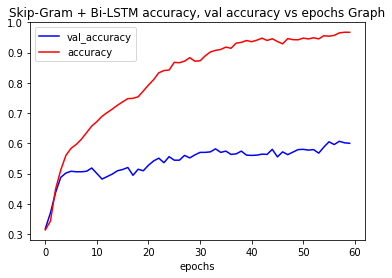

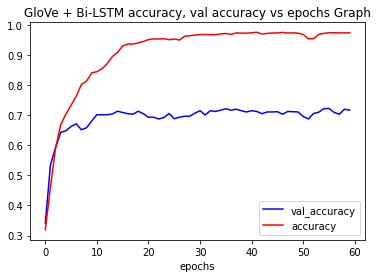

In [23]:
print("\tLstm\t\t\tBiLstm\t\t\tRnn")
print("sg",result_table[:3])
print("cbow",result_table[3:6])
print("glove",result_table[6:9])
print(history_sg_bi.history)
plt.title("Skip-Gram + Bi-LSTM accuracy, val accuracy vs epochs Graph")
plt.plot(history_sg_bi.history['val_accuracy'],c='b',label='val_accuracy')
plt.plot(history_sg_bi.history['accuracy'],c='r',label='accuracy')
plt.xlabel('epochs')
plt.legend()
# plt.yticks()
plt.show()
plt.title("GloVe + Bi-LSTM accuracy, val accuracy vs epochs Graph")
plt.plot(history_glove_bi.history['val_accuracy'],c='b',label='val_accuracy')
plt.plot(history_glove_bi.history['accuracy'],c='r',label='accuracy')
plt.xlabel('epochs')
plt.legend()
# plt.yticks()
plt.show()